In [67]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from datetime import datetime


import shutil
import pandas as pd

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
dir_str = "./nus-cs5242/"
shutil.rmtree(dir_str + "train_image/class", ignore_errors=True)
os.mkdir(dir_str + "train_image/class")
os.mkdir(dir_str + "train_image/class/0")
os.mkdir(dir_str + "train_image/class/1")
os.mkdir(dir_str + "train_image/class/2")

label = pd.read_csv(dir_str + "train_label.csv")
label_tupple = list(label.itertuples(index=False, name=None))

for i in range(len(label_tupple)):
    img_ext = str(label_tupple[i][0])
    img_class = str(label_tupple[i][1])
    
    shutil.copy(dir_str + "train_image/train_image/"+img_ext+".png", 
                dir_str + "train_image/class/"+img_class+"/"+img_ext+".png")

data_dir=dir_str + "train_image/class"
data_dir = pathlib.Path(data_dir)
print(data_dir)

nus-cs5242/train_image/class


In [43]:
# create tf datasets and load data, note: didn't use graysacle as all pretrained models over imagenet are RGB 
batch_size = 32
img_height = 512
img_width = 512
num_classes = 3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #labels=train_labels,
  #label_mode='int',
  #color_mode='grayscale',
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names


Found 1164 files belonging to 3 classes.
Using 1048 files for training.


In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  #labels=train_labels,
  #color_mode='grayscale',
  #label_mode='int',
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1164 files belonging to 3 classes.
Using 116 files for validation.


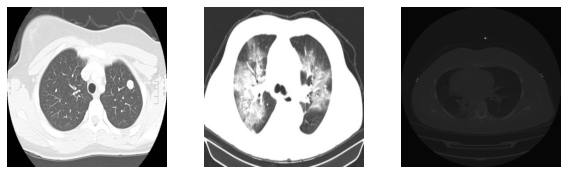

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [46]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(32, 512, 512, 3)
(32,)
(24, 512, 512, 3)
(24,)


In [29]:
#for image_batch, labels_batch in train_ds:
#    print(labels_batch[0])

In [141]:
#for images, labels in train_ds:
#    plt.imshow(images[1])

In [10]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Test transfer learning model ResNet50

In [47]:
# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=(512,512,3),
#                                               include_top=False,
#                                               weights='imagenet')


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

base_model = ResNet50(input_shape=(512,512,3),
                                               include_top=False,
                                               weights='imagenet')


In [48]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [49]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 2048)


In [50]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  175


In [51]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [52]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [53]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [54]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Normalization(),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [55]:
# construct model 

inputs = tf.keras.Input(shape=(512, 512, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [56]:
base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])


model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [57]:
model.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 512, 512, 3)       7         
_________________________________________________________________
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 23,593,866
Trainable params: 14,984,195
Non-trainable params: 8,609,671
__________________________________

In [58]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
33/33 [==============================] - 21s 651ms/step - loss: 0.8858 - accuracy: 0.5935 - val_loss: 0.6739 - val_accuracy: 0.6638
Epoch 2/30
33/33 [==============================] - 20s 607ms/step - loss: 0.5622 - accuracy: 0.7424 - val_loss: 0.4973 - val_accuracy: 0.7672
Epoch 3/30
33/33 [==============================] - 20s 607ms/step - loss: 0.4841 - accuracy: 0.7805 - val_loss: 0.5161 - val_accuracy: 0.7500
Epoch 4/30
33/33 [==============================] - 20s 612ms/step - loss: 0.4356 - accuracy: 0.7863 - val_loss: 0.5744 - val_accuracy: 0.7586
Epoch 5/30
33/33 [==============================] - 20s 604ms/step - loss: 0.4124 - accuracy: 0.8053 - val_loss: 0.6182 - val_accuracy: 0.7241
Epoch 6/30
33/33 [==============================] - 20s 607ms/step - loss: 0.3799 - accuracy: 0.8197 - val_loss: 0.5332 - val_accuracy: 0.7672
Epoch 7/30
33/33 [==============================] - 20s 610ms/step - loss: 0.3201 - accuracy: 0.8511 - val_loss: 0.8942 - val_accuracy: 0.7241

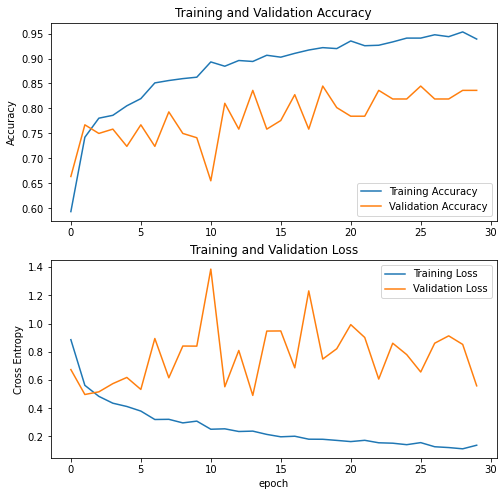

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
import os

output = []
    
test_folder = dir_str + "test_image/test_image"

for file in os.listdir(test_folder):
    filename = str(file).replace(".png","")
    image_path = os.path.join(test_folder, file)
    #print(filename, image_path)
    
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    label = class_names[np.argmax(score)]
    label = class_names[np.argmax(score)]

    output.append([filename, label])
    #print(
    #    "This image most likely belongs to {} with a {:.2f} percent confidence."
    #    .format(class_names[np.argmax(score)], 100 * np.max(score))
    #)
    

In [65]:
results = pd.DataFrame(output, columns = ['ID' , 'Label']) 
results.ID = results.ID.astype(int)
results = results.sort_values(by="ID")

In [68]:
results.to_csv(dir_str + "submission_resnet50_" + datetime.today().strftime('%Y-%m-%d-%H-%M-%S') + ".csv", index=False)